In [3]:
!pip install mesa

#La clase Model para manejar los agentes y la clase Agent para un definir un agente.
from mesa import Agent, Model

# Debido a que necesitamos varios agentes por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''DataCollector'', vamos a recuperar información del modelo.
from mesa.datacollection import DataCollector

# matplotlib lo vamos a utilizar para realizar una ''animación'' de mi modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

# Definimos otros paquete que vamos a usar para medir el tiempo de ejecución del modelo
import time
import datetime

MAXVAL = 10000

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 3.6 MB/s 
     |████████████████████████████████| 66 kB 1.4 MB/s 


In [207]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                                  [ 0, -1],           [ 0, +1],
                                  [+1, -1], [+1,  0], [+1, +1] ])
        self.count = 0
        
    def can_move(self, x, y):
        return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int( np.random.rand() * MAXVAL ) % len(self.options)
            x = self.pos[0] + self.options[i][0]
            y = self.pos[1] + self.options[i][1]
            if self.can_move(x, y):
              self.count += 1
              self.model.grid.move_agent(self, (x, y))
                
def get_grid(model):
    """ Esta función nos permite obtener el estado de los diferentes agentes.
        *param* model : Modelo del que obtendrá la información. 
        *return* una matriz con la información del estado de cada uno de los agentes."""
    grid = np.zeros( (model.grid.width, model.grid.height) )
    for x in range (model.grid.width):
        for y in range (model.grid.height):
            if model.grid.is_cell_empty( (x, y) ) :
                grid[x][y] = model.floor[x][y] * 2
            else:
                grid[x][y] = 1
    #print (grid)
    return grid
    
class RobotVacuumCleanerModel(Model):
    def __init__(self, width, height, num_agents, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros( (width, height) )
        self.myArray = []
        
        # Create agents
        for i in range(self.num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a, (0, 0))
            self.schedule.add(a)
            
        # Initializate the ''dirty'' cells
        amount = int((width * height) * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                x = int(np.random.rand() * MAXVAL) % width
                y = int(np.random.rand() * MAXVAL) % height
                if self.floor[x][y] == 0:
                    self.floor[x][y] = 1
                    finished = True
        #print(self.floor)
                    
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})
        
    def is_all_clean(self):
        return np.all(self.floor == 0)
    
    def percentage_clean(self):
      count = 0
      for i in range(self.grid.width):
        for j in range(self.grid.height):
          if self.floor[i][j] == 0:
            count += 1
      percentage = (count * 100) / (self.grid.width * self.grid.height)
      return percentage

    def get_count(self):
      myAvg = 0
      for x in range (self.grid.width):
        for y in range (self.grid.height):
            if not self.grid.is_cell_empty((x, y)) :
              self.myArray.append(self.grid[(x,y)][0].count)
              myAvg += self.grid[(x,y)][0].count
      myAvg = myAvg / self.num_agents
      return myAvg

    def get_max(self):
      maxCount = 0
      for x in range (self.grid.width):
        for y in range (self.grid.height):
            if not self.grid.is_cell_empty((x, y)) :
              if self.grid[(x,y)][0].count > maxCount:
                maxCount = self.grid[(x,y)][0].count
      return maxCount

            
    def step(self):
        """ Ejecuta un paso de la simulación."""
        self.datacollector.collect(self)
        self.schedule.step()

In [237]:
# Definimos el tamaño del Grid
GRID_SIZE = 20

# Definimos el número máximo de generaciones a correr
MAX_GENERATIONS = 200

# Registramos el tiempo de inicio y ejecutamos la simulación
start_time = time.time()
time_exec = 0

model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, 30, 0.7)
model2 = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE, 30, 0.7)

i = 1
while i <= MAX_GENERATIONS and not model.is_all_clean():
    model.step()
    i += 1
print("Escenario 1. Número de steps máximos: ", MAX_GENERATIONS)
print("Número de agentes: ", model.num_agents)
print("Porcentaje de celdas limpias: ", model.percentage_clean(), "%")
print("Movimiento promedio de los agentes: ", model.get_count())
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))), "\n")

start_time2 = time.time()
MAX_STEPS = 0
while not model2.is_all_clean():
    model2.step()
    MAX_STEPS += 1

print("Escenario 2. Celdas completamente limpias")
print("Número de agentes: ", model.num_agents)
print("Porcentaje de celdas limpias: ", model2.percentage_clean(), "%")
print("Movimiento promedio de los agentes: ", model2.get_count())
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time2))))

Escenario 1. Número de steps máximos:  200
Número de agentes:  30
Porcentaje de celdas limpias:  96.5 %
Movimiento promedio de los agentes:  170.96666666666667
Tiempo de ejecución: 0:00:00.161794 

Escenario 2. Celdas completamente limpias
Número de agentes:  30
Porcentaje de celdas limpias:  100.0 %
Movimiento promedio de los agentes:  198.16666666666666
Tiempo de ejecución: 0:00:00.198618


(array([1., 0., 0., 2., 1., 4., 5., 8., 5., 4.]),
 array([137., 142., 147., 152., 157., 162., 167., 172., 177., 182., 187.]),
 <a list of 10 Patch objects>)

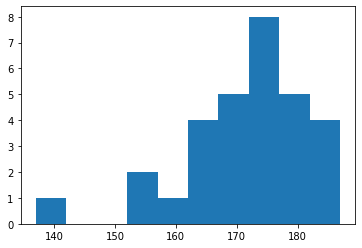

In [238]:
agents_step_count = [agent.count for agent in model.schedule.agents]
plt.hist(agents_step_count)

(array([5., 3., 0., 0., 5., 9., 3., 0., 2., 3.]),
 array([194. , 197.6, 201.2, 204.8, 208.4, 212. , 215.6, 219.2, 222.8,
        226.4, 230. ]),
 <a list of 10 Patch objects>)

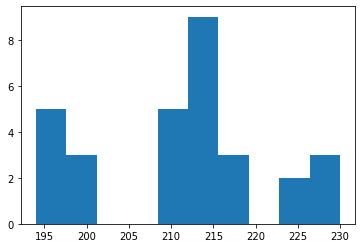

In [239]:
agents_step_count2 = [agent.count for agent in model2.schedule.agents]
plt.hist(agents_step_count2)

In [211]:
# Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()
all_grid2 = model2.datacollector.get_model_vars_dataframe()

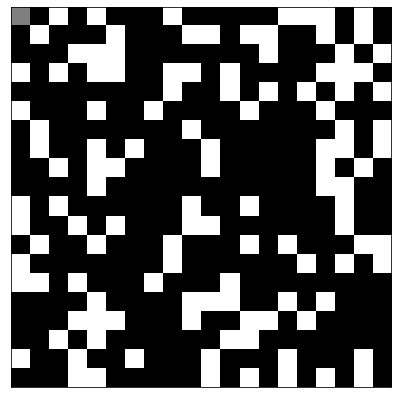

In [212]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim1 = animation.FuncAnimation(fig, animate, frames=MAX_GENERATIONS)

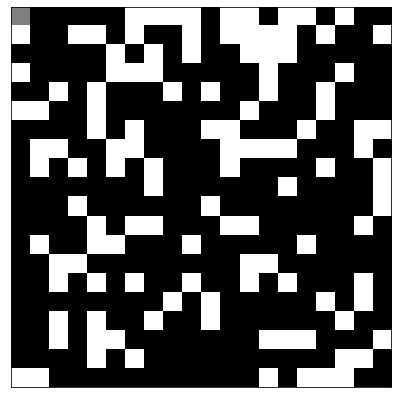

In [213]:
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid2.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid2.iloc[i][0])
    
anim2 = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)

In [214]:
anim1

In [215]:
anim2